<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/results/MI_GAN_t2_%5Bconvergence_failure2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries and mount the drive

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.1.0-rc1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading train, validation and test sets

In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2
# I'll focus now on synthesizing T2 from T1

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=False)
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=True)
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], shuffle=True)
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

modalities = ['MR_T1_mri', 'MR_T2_mri', 'MR_T1c_mri', 'MR_Flair_mri', 'OT_mri']

## Load some useful functions


In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record, ot=False):

    t1, t2, t1c, tflair = raw_record[modalities[0]], raw_record[modalities[1]], raw_record[modalities[2]], raw_record[modalities[3]]
    t1 = process_batch(t1)
    t2 = process_batch(t2)
    t1c = process_batch(t1c)
    tflair = process_batch(tflair)
    if ot:      # if ot is true, I'll retrieve also the segmentation from the raw_record
        segmentation = process_batch(raw_record[modalities[4]])
        return t1, t2, t1c, tflair, segmentation
    return t1, t2, t1c, tflair

In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
    if len(args) == 5:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 6:      # crop also the segmentation, if is given as additional argument
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        return image0, image1, image2, image3, image4, image5
    return image0, image1, image2, image3

In [0]:
def retrieve_tumor_area(ground_truth, prediction, segmentation):
    ground_truth_np = ground_truth.numpy()
    segmentation_np = segmentation.numpy()
    prediction_np = prediction.numpy()

    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction_np[idx] = segmentation_np[idx]

    return ground_truth_np, prediction_np      # Now the images are ready to be evaluated

## Evaluate GAN

In [0]:
def evaluate_GAN(model, dataset, set_type, evaluate_tumor_area=False, print_loss=False, epc=99):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    
    ######## remove this ######
    num_batches = 10
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    if print_loss:
        container_gen = tf.TensorArray(tf.float32, size=num_batches)     
        container_disc = tf.TensorArray(tf.float32, size=num_batches)
    
    idx = 0
    #for idx, raw_record in dataset.enumerate():
    for raw_record in dataset.take(10):
        t1, t2, t1c, tflair, segmentation = take_images_from_raw(raw_record, ot=True)
        # preparing the input to the generator
        t2_original = t2
        # INPUT IMPUTATION
        gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
        input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)

        # generate the prediction            
        prediction = model(input_tensor, training=False)
        # extracting the t2_prediction from the predictions (I'm only interested in T2)
        t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
        t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

        # crop the images
        t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, tflair, t2_original, t2_generated, segmentation)
        if evaluate_tumor_area:
            ground_truth_masked, prediction_masked = retrieve_tumor_area(t2_original_cr, t2_generated_cr, segmentation_cr)
        #if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83) and evaluate_tumor_area:
        #    plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, ground_truth_masked, prediction_masked)
        # ----> to restore the above code, change also the below line with 'elif' instead of 'if'

        # let's print only 5 images per time. 
    
        if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83):
            if (epc % 5 == 1) and evaluate_tumor_area:
                # print tumor areas only if the bool is set to True and the epoch is % n == 1 (is a multiple of n)
                plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, ground_truth_masked, prediction_masked)
            else:
                plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr)

        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(t2_generated_cr)
        ground_truth_normalized_cr = mean_normalize(t2_original_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:
            # discard black images from pred and gt
            prediction_masked_normalized = mean_normalize(prediction_masked)
            ground_truth_masked_normalized = mean_normalize(ground_truth_masked) 
            #if (epc % 2 == 1) and idx == 0:
            #    plot_images(ground_truth_masked, prediction_masked)
            mean, std, psnr = compute_psnr(ground_truth_masked_normalized, prediction_masked_normalized)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse(ground_truth_masked_normalized, prediction_masked_normalized)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction_masked_normalized)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)

        # COMPUTES VALIDATION LOSSES FOR THE GENERATOR AND THE DISCRIMINATOR
        if print_loss:
            ####################################
            Xr = tf.concat([t1, t1c, t2_original, tflair], 3)
            Xi = tf.concat([t1, t1c, t2_generated, tflair], 3)

            zeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)
            ones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)
            Lr = tf.concat([ones, zeros, ones, ones], 3)   # t1, t2, t1c, tflair
            Lar = tf.concat([ones, ones, ones, ones], 3)   # t1, t2, t1c, tflair

            disc_generated_output_gen = discriminator([Xi, Xr], training=True)
            disc_generated_output_disc = discriminator([Xr, Xi], training=True)
            disc_real_output = discriminator([Xr, Xr], training=True)

            gen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output_gen, t2_generated, t2_original, Lar)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output_disc, Lr, Lar) * 0.5

            container_gen = container_gen.write(idx, gen_total_loss)
            container_disc = container_disc.write(idx, disc_loss)
            ###############################
        idx += 1

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        mean_psnr_tumor = tf.reduce_mean(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        std_psnr_tumor = tf.math.reduce_std(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))
    if print_loss:
        container_disc = container_disc.stack()
        container_gen = container_gen.stack()
        mean_gen = tf.reduce_mean(tf.boolean_mask((container_gen), tf.math.is_finite(container_gen)))
        std_gen = tf.math.reduce_std(tf.boolean_mask((container_gen), tf.math.is_finite(container_gen)))
        mean_disc = tf.reduce_mean(tf.boolean_mask((container_disc), tf.math.is_finite(container_disc)))
        std_disc = tf.math.reduce_std(tf.boolean_mask((container_disc), tf.math.is_finite(container_disc)))
        print()
        print("Generator loss on {} set: {} ± {}".format(set_type, (f'{mean_gen:.4f}'), (f'{std_gen:.4f}')))
        print("Discriminator loss on {} set: {} ± {}".format(set_type, (f'{mean_disc:.4f}'), (f'{std_disc:.4f}')))
        
    if tf.equal(print_loss, True) and tf.equal(evaluate_tumor_area, False):
        return mean_psnr, mean_mse, mean_ssim, mean_gen, mean_disc
    elif tf.equal(print_loss, False) and tf.equal(evaluate_tumor_area, True):
        return mean_psnr, mean_mse, mean_ssim, mean_psnr_tumor, mean_mse_tumor, mean_ssim_tumor
    elif tf.equal(print_loss, True) and tf.equal(evaluate_tumor_area, True):
        return mean_psnr, mean_mse, mean_ssim, mean_psnr_tumor, mean_mse_tumor, mean_ssim_tumor, mean_gen, mean_disc
    return mean_psnr, mean_mse, mean_ssim

In [13]:
for i in range(17):
    if (i % 5 == 1):
        print(i)

1
6
11
16


In [0]:
def plot_loss(g_l, d_l):        
    f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
    f.subplots_adjust(hspace=0.4)
    max_epoch = g_l.shape[0]       # args[0] 
    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, g_l, label='Generator loss')
    ax1.plot(epoch_list, d_l, label='Discriminator Loss')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Loss Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('LOSS on validation set')
    l1 = ax1.legend(loc="best")

In [0]:
def plot_metrics(*args):        # arguments will be, in order: psnr, mse, ssim, psnr_tumor*, mse_tumor*, ssim_tumor*
    tumor_area = False          # arguments with * are optional
    if len(args) == 6:
        tumor_area = True

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
    f.subplots_adjust(hspace=0.4)

    max_epoch = (args[0]).shape[0]       # args[0] 

    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, args[0], label='PSNR')
    if tumor_area: 
        ax1.plot(epoch_list, args[3], label='PSNR on tumor area')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('PSNR Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('PSNR')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, args[1], label='MSE')
    if tumor_area: 
        ax2.plot(epoch_list, args[4], label='MSE on tumor area')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('MSE Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('MSE')
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, args[2], label='SSIM')
    if tumor_area: 
        ax3.plot(epoch_list, args[5], label='SSIM on tumor area')
    ax3.set_xticks(np.arange(1, max_epoch, 5))
    ax3.set_ylabel('SSIM Value')
    ax3.set_xlabel('Epoch')
    ax3.set_title('SSIM')
    l3 = ax3.legend(loc="best")


In [0]:
# this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images(*args, images_to_print=5): 
    if images_to_print == 5: x = 15
    elif images_to_print == 32: x = 90
    if len(args) == 3:
        display_list = [args[0], args[1], args[2]]     # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (x , 9)
    elif len(args) == 2:
        display_list = [args[0], args[1]]     # input and gt
        title = ['GT in tumor area', 'Pred in tumor area']
        figsize = (x , 7)
    elif len(args) == 4:
        display_list = [args[0], args[1], args[2], args[3]]     # gt, prediction, gt_masked, prediction_masked
        title = ['Ground Truth', 'Prediction', 'GT in tumor area', 'Pred in tumor area']
        figsize = (x , 12)
    elif len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]     # input, gt, prediction, gt_masked, prediction_masked
        title = ['T1', 'T1c', 'Tflair', 'T2 ground truth', 'T2 generated']
        figsize = (x , 15)
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        for j in range(images_to_print):    # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(len(args)+1, images_to_print, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

In [0]:
# this method was tested to work with 5, 7 and 32 images.
def plot_images_new(*args): 

    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['T1', 'T1c', 'T1flair', 'T2 - ground Truth', 'T2 - Predicted Image']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)
    elif len(args) == 7:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6]]   # input, gt and prediction
        title = ['T1', 'T1c', 'T1flair', 'T2 - ground Truth', 'T2 - Predicted Image', 'GT Tumor', 'Pred Tumor']
        figsize = (22, 6)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

In [18]:
"""evaluate_tumor_area = True
for idx, raw_record in testing.enumerate():
        t1, t2, t1c, tflair, segmentation = take_images_from_raw(raw_record, ot=True)
        # preparing the input to the generator
        t2_original = t2
        # INPUT IMPUTATION
        gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
        input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)

        # generate the prediction            
        prediction = generator(input_tensor, training=False)
        # extracting the t2_prediction from the predictions (I'm only interested in T2)
        t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
        t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

        # crop the images
        t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, tflair, t2_original, t2_generated, segmentation)
        if evaluate_tumor_area:
            ground_truth_masked, prediction_masked = retrieve_tumor_area(t2_original_cr, t2_generated_cr, segmentation_cr)
        
        if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83):
                plot_images_new(t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, ground_truth_masked, prediction_masked)
                """

"evaluate_tumor_area = True\nfor idx, raw_record in testing.enumerate():\n        t1, t2, t1c, tflair, segmentation = take_images_from_raw(raw_record, ot=True)\n        # preparing the input to the generator\n        t2_original = t2\n        # INPUT IMPUTATION\n        gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)\n        input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)\n\n        # generate the prediction            \n        prediction = generator(input_tensor, training=False)\n        # extracting the t2_prediction from the predictions (I'm only interested in T2)\n        t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator\n        t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze\n\n        # crop the images\n        t1_cr, t1c_cr, tflair_cr, t2_original_cr, t2_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, tflair, t2_original, t

In [19]:
"""idx = 0
#for raw_record in validation.take(40):
for idx, raw_record in enumerate(validation):
    #inp, ground_truth, segmentation = take_images_from_raw(raw_record, True)
    
    inp, ground_truth, segmentation = take_images_from_raw(raw_record, ot=True)
    gen_output = generator(inp, training=False)
    inp, ground_truth, gen_output, segmentation = resize_with_crop(inp, ground_truth, gen_output, segmentation)
    ground_truth_masked, prediction_masked = retrieve_tumor_area(ground_truth, gen_output, segmentation)
    
    # id = 46.. check it
    if idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:
        plot_images_new(inp, ground_truth, gen_output)
    idx += 1"""

'idx = 0\n#for raw_record in validation.take(40):\nfor idx, raw_record in enumerate(validation):\n    #inp, ground_truth, segmentation = take_images_from_raw(raw_record, True)\n    \n    inp, ground_truth, segmentation = take_images_from_raw(raw_record, ot=True)\n    gen_output = generator(inp, training=False)\n    inp, ground_truth, gen_output, segmentation = resize_with_crop(inp, ground_truth, gen_output, segmentation)\n    ground_truth_masked, prediction_masked = retrieve_tumor_area(ground_truth, gen_output, segmentation)\n    \n    # id = 46.. check it\n    if idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:\n        plot_images_new(inp, ground_truth, gen_output)\n    idx += 1'

## Min-max normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/73032b45bffd5e5140483fbe1ed49bf174f1962d)

In [0]:
def min_max_rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def min_max_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = min_max_rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

## Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized
    

## Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            x = mean_rescale(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

## Defining models and optimizers

In [28]:
!pip install -q  --no-deps tensorflow-addons~=0.6
import tensorflow_addons as tfa

     |████████████████████████████████| 1.8MB 2.7MB/s 


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 4

In [0]:
# in pix2pix vanilla there isn't the droput in the downsample step.
# also, the relu before or after the dropout doesn't seem to make any difference. 
# for more see: https://sebastianraschka.com/faq/docs/dropout-activation.html

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        #result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ReLU())
    result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    #result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,4], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(4, 4, apply_instancenorm=False),
    downsample(64, 4),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(1024, 4, apply_dropout=True),
    upsample(1024, 4, apply_dropout=True),
    upsample(1024, 4),
    upsample(1024, 4), 
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 2)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  idx = 0
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    idx += 1

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def discriminator_block(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    result.add(tf.keras.layers.BatchNormalization())
    #result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 4], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 4], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, 4*2)

  down1 = discriminator_block(8, 4, False)(x) # (bs, 128, 128, 64)
  down2 = discriminator_block(64, 4)(down1) # (bs, 64, 64, 128)
  down3 = discriminator_block(128, 4)(down2) # (bs, 32, 32, 256)
  down4 = discriminator_block(256, 4)(down3) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  
  last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, kernel_initializer=initializer)(zero_pad1) # (bs, 15, 15, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()
#discriminator.summary()

In [0]:
# let's generate T2, giving T1, T1c, Tflair and a black T2.
# first I have to do input imputation. so missing sequence (T2) is imputed with zero-value and fed to the generator.
generator = Generator()
#generator.summary()

In [0]:
def generate_images(model, t1, t2, t1c, tflair):
    # INPUT IMPUTATION
    gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
    input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)
    # batch of size 32 containing 4 channels (4 modalities) with 256x256 images

    prediction = model(input_tensor, False)

    t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
    t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

    t1_cr, t2_cr, t1c_cr, tflair_cr, t2_generated_cr = resize_with_crop(t1, t2, t1c, tflair, t2_generated)
    plot_images(t1_cr, t1c_cr, tflair_cr, t2_cr, t2_generated_cr )

In [0]:
LAMBDA = 0.9

In [0]:
def generator_loss(disc_generated_output, gen_output, target, lar):
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(gen_output - target))

    # mean squared error
    l2_loss = tf.reduce_mean(tf.math.squared_difference(disc_generated_output, lar))

    total_gen_loss = LAMBDA * l1_loss + ((1-LAMBDA) * l2_loss)

    return total_gen_loss, l1_loss, l2_loss

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output, lr, lar):

    real_loss = tf.reduce_mean(tf.math.squared_difference(disc_real_output, lar))
    generated_loss = tf.reduce_mean(tf.math.squared_difference(disc_generated_output, lr))

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [41]:
# processing the input of the discriminator
"""
t2_original = t2

Xr = tf.concat([t1, t1c, t2_original, tflair], 3)
Xi = tf.concat([t1, t1c, t2_generated, tflair], 3)

print(Xr.shape, Xi.shape)

# DISCRIMINATOR D(Xr, Xi)

disc_output = discriminator([Xr, Xi], training=False)
disc_output.shape
"""

'\nt2_original = t2\n\nXr = tf.concat([t1, t1c, t2_original, tflair], 3)\nXi = tf.concat([t1, t1c, t2_generated, tflair], 3)\n\nprint(Xr.shape, Xi.shape)\n\n# DISCRIMINATOR D(Xr, Xi)\n\ndisc_output = discriminator([Xr, Xi], training=False)\ndisc_output.shape\n'

In [42]:
"""
# Now I have to compute the discriminator loss between disc_output and Lr, both with shape (32, 15, 15, 4)
zeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)
ones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)
Lr = tf.concat([ones, zeros, ones, ones], 3)   # t1, t2, t1c, tflair
# Lr is a 2d tensor with shape (15, 15). It's an image based-target where each channel corresponds to a sequence.
# black is sequence is fake, white if the sequence is real.

Lar = tf.concat([ones, ones, ones, ones], 3)   # t1, t2, t1c, tflair


disc_generated_output_gen = discriminator([Xi, Xr], training=False)
disc_generated_output_disc = discriminator([Xr, Xi], training=False)
disc_real_output = discriminator([Xr, Xr], training=False)

gen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output_gen, t2_generated, t2_original, Lar)
disc_loss = discriminator_loss(disc_real_output, disc_generated_output_disc, Lr, Lar)

print(gen_total_loss.numpy(), gen_l1_loss.numpy(), gen_l2_loss.numpy())
print(disc_loss.numpy(), disc_loss.numpy()*0.5)
"""

"\n# Now I have to compute the discriminator loss between disc_output and Lr, both with shape (32, 15, 15, 4)\nzeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)\nones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)\nLr = tf.concat([ones, zeros, ones, ones], 3)   # t1, t2, t1c, tflair\n# Lr is a 2d tensor with shape (15, 15). It's an image based-target where each channel corresponds to a sequence.\n# black is sequence is fake, white if the sequence is real.\n\nLar = tf.concat([ones, ones, ones, ones], 3)   # t1, t2, t1c, tflair\n\n\ndisc_generated_output_gen = discriminator([Xi, Xr], training=False)\ndisc_generated_output_disc = discriminator([Xr, Xi], training=False)\ndisc_real_output = discriminator([Xr, Xr], training=False)\n\ngen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output_gen, t2_generated, t2_original, Lar)\ndisc_loss = discriminator_loss(disc_real_output, disc_generated_output_disc, Lr, Lar)\n\nprint(gen_total_loss.numpy(), gen_l1_loss

In [0]:
#plt.imshow(np.squeeze(ones[0]), cmap='bone')

#print((tf.math.reduce_min(ones)).numpy(), (tf.math.reduce_max(ones)).numpy())
#print((tf.math.reduce_min(zeros)).numpy(), (tf.math.reduce_max(zeros)).numpy())

In [44]:
"""print(tf.math.reduce_min(disc_output[:,:,:,0]), tf.math.reduce_max(disc_output[:,:,:,0]))
print(tf.math.reduce_min(disc_output[:,:,:,1]), tf.math.reduce_max(disc_output[:,:,:,1]))
print(tf.math.reduce_min(disc_output[:,:,:,2]), tf.math.reduce_max(disc_output[:,:,:,2]))
print(tf.math.reduce_min(disc_output[:,:,:,3]), tf.math.reduce_max(disc_output[:,:,:,3]))

print(tf.math.reduce_min(Lr[:,:,:,0]), tf.math.reduce_max(Lr[:,:,:,0]))
print(tf.math.reduce_min(Lr[:,:,:,1]), tf.math.reduce_max(Lr[:,:,:,1]))
print(tf.math.reduce_min(Lr[:,:,:,2]), tf.math.reduce_max(Lr[:,:,:,2]))
print(tf.math.reduce_min(Lr[:,:,:,3]), tf.math.reduce_max(Lr[:,:,:,3]))"""

'print(tf.math.reduce_min(disc_output[:,:,:,0]), tf.math.reduce_max(disc_output[:,:,:,0]))\nprint(tf.math.reduce_min(disc_output[:,:,:,1]), tf.math.reduce_max(disc_output[:,:,:,1]))\nprint(tf.math.reduce_min(disc_output[:,:,:,2]), tf.math.reduce_max(disc_output[:,:,:,2]))\nprint(tf.math.reduce_min(disc_output[:,:,:,3]), tf.math.reduce_max(disc_output[:,:,:,3]))\n\nprint(tf.math.reduce_min(Lr[:,:,:,0]), tf.math.reduce_max(Lr[:,:,:,0]))\nprint(tf.math.reduce_min(Lr[:,:,:,1]), tf.math.reduce_max(Lr[:,:,:,1]))\nprint(tf.math.reduce_min(Lr[:,:,:,2]), tf.math.reduce_max(Lr[:,:,:,2]))\nprint(tf.math.reduce_min(Lr[:,:,:,3]), tf.math.reduce_max(Lr[:,:,:,3]))'

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Let's load now the generator, discriminator weights and optimizers status from the checkpoints



Uncomment this only to continue to train an already trained network. Otherwise it will be trained a new GAN

In [46]:

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/train1"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


# if a checkpoint exists, restore the latest checkpoint.

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')


"""
idx = 0     # this is the checkpoint that will be restored.

if len(ckpt_manager.checkpoints) > 0:    # then there is a checkpoint to restore
    ckpt.restore(ckpt_manager.checkpoints[idx])
    print ('Latest checkpoint restored!!')
"""
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()


Optimizers and models defined but not initialized? True
Optimizers and models defined but not initialized? True



Now the GAN is restored to the previous checkpoint and ready to be trained again !!!

##**TRAIN STEP**

In [0]:
@tf.function
def train_step(t1, t2, t1c, tflair):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        t2_original = t2
        # INPUT IMPUTATION
        gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
        input_tensor = tf.concat([t1, gt_imputed, t1c, tflair], 3)
        
        prediction = generator(input_tensor, True)
        t2_generated = prediction[:, :, :, 1]     # this will be used to compute the loss and then fed to the discriminator
        t2_generated = tf.expand_dims(t2_generated, axis=3)     # cause in plot_images it will tf.squeeze

        Xr = tf.concat([t1, t1c, t2_original, tflair], 3)
        Xi = tf.concat([t1, t1c, t2_generated, tflair], 3)

        zeros = tf.zeros((32, 15, 15, 1), dtype=tf.dtypes.float32)
        ones = tf.ones((32, 15, 15, 1), dtype=tf.dtypes.float32)
        Lr = tf.concat([ones, zeros, ones, ones], 3)   # t1, t2, t1c, tflair
        Lar = tf.concat([ones, ones, ones, ones], 3)   # t1, t2, t1c, tflair

        disc_generated_output_gen = discriminator([Xi, Xr], training=True)
        disc_generated_output_disc = discriminator([Xr, Xi], training=True)
        disc_real_output = discriminator([Xr, Xr], training=True)

        # SELECTIVE LOSS COMPUTATION & SELECTIVE DISCRIMINATION IN D
        gen_total_loss, gen_l1_loss, gen_l2_loss = generator_loss(disc_generated_output_gen, t2_generated, t2_original, Lar)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output_disc, Lr, Lar) * 0.5

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [0]:
def fit(train_ds, epochs, val_ds, save_checkpoint, epochs_already_trained, tumor_area, loss):

    psnr_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    mse_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    ssim_to_plot = tf.TensorArray(tf.float32, size=epochs+1) 
    if tumor_area:
        psnr_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        mse_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        ssim_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1) 
    if loss:
        g_loss_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
        d_loss_to_plot = tf.TensorArray(tf.float32, size=epochs+1)


    for epoch in range(epochs):
    
        if epoch == 0:
            ########################### ALL THIS BLOCK IS TO VALIDATE THE RESULTS (and plot them) ##########
            if tf.equal(tumor_area, True) and tf.equal(loss, False):
                psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch)
            elif tf.equal(tumor_area, False) and tf.equal(loss, True):
                psnr, mse, ssim, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch)
            elif tf.equal(tumor_area, True) and tf.equal(loss, True):
                psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch)
            else: 
                psnr, mse, ssim = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
            psnr_to_plot = psnr_to_plot.write(epoch, psnr)
            mse_to_plot = mse_to_plot.write(epoch, mse)
            ssim_to_plot = ssim_to_plot.write(epoch, ssim)
            if tumor_area:
                psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch, psnr_tumor)
                mse_to_plot_tumor = mse_to_plot_tumor.write(epoch, mse_tumor)
                ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch, ssim_tumor)
            if loss:
                g_loss_to_plot = g_loss_to_plot.write(epoch, g_loss)
                d_loss_to_plot = d_loss_to_plot.write(epoch, d_loss)
            ################################################################################################

        """     
        # VALIDATE THE RESULTS
        for raw_record in val_ds.take(1):
            t1, t2, t1c, tflair = take_images_from_raw(raw_record)
            generate_images(generator, t1, t2, t1c, tflair)
            """
        start = time.time()

        print()
        print("Epoch: ", epoch + 1 + epochs_already_trained)     # I start with epoch 1: the first iteration (not epoch 0)

        # Train
        n = 0
        #for raw_record in train_ds.take(100):
        for idx, raw_record in train_ds.enumerate():
            n += 1
            t1, t2, t1c, tflair = take_images_from_raw(raw_record)
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
                print(n+1)
            # This is the actual TRAINING STEP
            train_step(t1, t2, t1c, tflair)
        ########################### ALL THIS BLOCK IS TO VALIDATE THE RESULTS (and plot them) ##########
        if tf.equal(tumor_area, True) and tf.equal(loss, False):
            psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch+1)
        elif tf.equal(tumor_area, False) and tf.equal(loss, True):
            psnr, mse, ssim, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch+1)
        elif tf.equal(tumor_area, True) and tf.equal(loss, True):
            psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, g_loss, d_loss = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss, epoch+1)
        else: 
            psnr, mse, ssim = evaluate_GAN(generator, val_ds, 'validation', tumor_area, loss)
        psnr_to_plot = psnr_to_plot.write(epoch+1, psnr)
        mse_to_plot = mse_to_plot.write(epoch+1, mse)
        ssim_to_plot = ssim_to_plot.write(epoch+1, ssim)
        if tumor_area:
            psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch+1, psnr_tumor)
            mse_to_plot_tumor = mse_to_plot_tumor.write(epoch+1, mse_tumor)
            ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch+1, ssim_tumor)
        if loss:
            g_loss_to_plot = g_loss_to_plot.write(epoch+1, g_loss)
            d_loss_to_plot = d_loss_to_plot.write(epoch+1, d_loss)
            ################################################################################################
        print()

        if (epoch + 1) % 5 == 0 and save_checkpoint:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1 + epochs_already_trained,
                                                            time.time()-start))
    if save_checkpoint:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving {} checkpoint for epoch {} at {}'.format("FINAL", epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))
        
    psnr_to_plot = psnr_to_plot.stack()
    mse_to_plot = mse_to_plot.stack()
    ssim_to_plot = ssim_to_plot.stack()
    if tumor_area:
        psnr_to_plot_tumor = psnr_to_plot_tumor.stack()
        mse_to_plot_tumor = mse_to_plot_tumor.stack()
        ssim_to_plot_tumor = ssim_to_plot_tumor.stack()
    if loss:
        g_loss_to_plot = g_loss_to_plot.stack()
        d_loss_to_plot = d_loss_to_plot.stack()
        
    if tf.equal(loss, True) and tf.equal(tumor_area, False):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, g_loss_to_plot, d_loss_to_plot
    elif tf.equal(loss, False) and tf.equal(tumor_area, True):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_tumor, mse_to_plot_tumor, ssim_to_plot_tumor
    elif tf.equal(loss, True) and tf.equal(tumor_area, True):
        return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_tumor, mse_to_plot_tumor, ssim_to_plot_tumor, g_loss_to_plot, d_loss_to_plot
    return psnr_to_plot, mse_to_plot, ssim_to_plot
        

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

## Fit of the model (at the end it will also save the models)

I save the models (I would need to save only the generator to be precise) in the same cell of the fitting because Google Colab, with long-run execution, doesn't allow to execute other cells after the one where I call 'fit'

Suggestion: train for around 35 epochs. Long-run are discouraged since Google Colab will crash.
Last time it arrived until the 43th epoch (409 seconds each).
So MAX TRAINING TIME ALLOWED: almost 5 hours. -> after that GPU won't be available for 8 hours or so

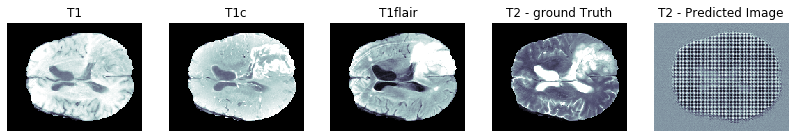

PSNR on validation set: 10.0897 ± 2.5216
MSE on validation set: 0.1095 ± 0.0410
SSIM on validation set: -0.0973 ± 0.0997

PSNR wrt tumor area on validation set: 15.5092 ± 5.9442
MSE wrt tumor area on validation set: 0.0481 ± 0.0377
SSIM wrt tumor area on validation set: 0.0403 ± 0.3811

Generator loss on validation set: 0.2960 ± 0.0410
Discriminator loss on validation set: 1.8187 ± 0.0373

Epoch:  1
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
.........................................................................

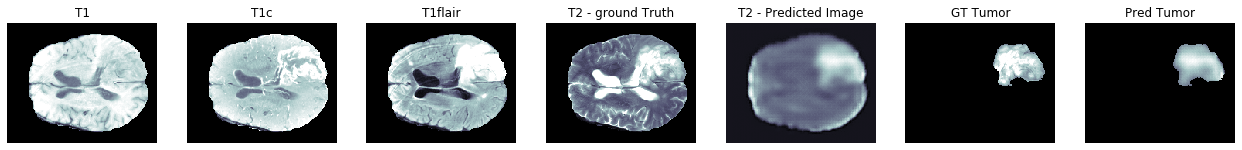

PSNR on validation set: 18.1785 ± 3.0442
MSE on validation set: 0.0182 ± 0.0091
SSIM on validation set: 0.6395 ± 0.1366

PSNR wrt tumor area on validation set: 31.1110 ± 7.4068
MSE wrt tumor area on validation set: 0.0018 ± 0.0019
SSIM wrt tumor area on validation set: 0.9618 ± 0.0343

Generator loss on validation set: 0.0523 ± 0.0203
Discriminator loss on validation set: 0.1110 ± 0.0390

Time taken for epoch 1 is 792.0156638622284 sec


Epoch:  2
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

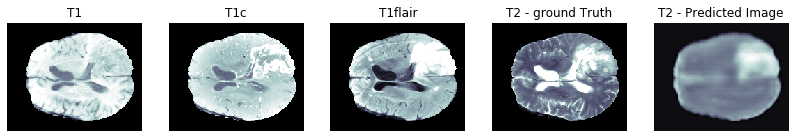

PSNR on validation set: 18.8194 ± 2.5510
MSE on validation set: 0.0148 ± 0.0062
SSIM on validation set: 0.6634 ± 0.1251

PSNR wrt tumor area on validation set: 31.8977 ± 7.0056
MSE wrt tumor area on validation set: 0.0012 ± 0.0010
SSIM wrt tumor area on validation set: 0.9660 ± 0.0270

Generator loss on validation set: 0.0364 ± 0.0087
Discriminator loss on validation set: 0.0848 ± 0.0167

Time taken for epoch 2 is 785.6623578071594 sec


Epoch:  3
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

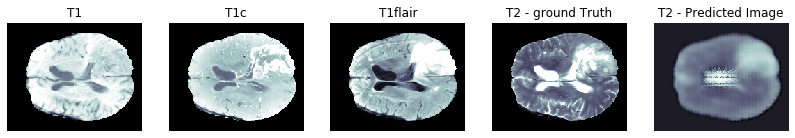

PSNR on validation set: 18.5171 ± 2.4012
MSE on validation set: 0.0157 ± 0.0062
SSIM on validation set: 0.6370 ± 0.1377

PSNR wrt tumor area on validation set: 31.4184 ± 6.8905
MSE wrt tumor area on validation set: 0.0013 ± 0.0010
SSIM wrt tumor area on validation set: 0.9635 ± 0.0281

Generator loss on validation set: 0.0417 ± 0.0123
Discriminator loss on validation set: 0.0347 ± 0.0171

Time taken for epoch 3 is 785.8030636310577 sec


Epoch:  4
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

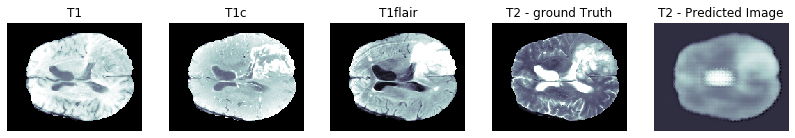

PSNR on validation set: 18.7492 ± 2.2886
MSE on validation set: 0.0148 ± 0.0058
SSIM on validation set: 0.6327 ± 0.1383

PSNR wrt tumor area on validation set: 31.5457 ± 7.1552
MSE wrt tumor area on validation set: 0.0013 ± 0.0009
SSIM wrt tumor area on validation set: 0.9632 ± 0.0281

Generator loss on validation set: 0.0443 ± 0.0123
Discriminator loss on validation set: 0.0371 ± 0.0257

Time taken for epoch 4 is 785.6664929389954 sec


Epoch:  5
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

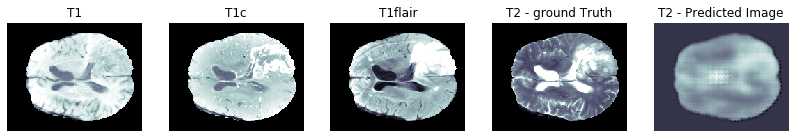

PSNR on validation set: 18.5136 ± 2.3235
MSE on validation set: 0.0157 ± 0.0061
SSIM on validation set: 0.6181 ± 0.1391

PSNR wrt tumor area on validation set: 31.4038 ± 7.3624
MSE wrt tumor area on validation set: 0.0014 ± 0.0011
SSIM wrt tumor area on validation set: 0.9632 ± 0.0294

Generator loss on validation set: 0.0428 ± 0.0082
Discriminator loss on validation set: 0.0175 ± 0.0121

Time taken for epoch 5 is 785.6634831428528 sec


Epoch:  6
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

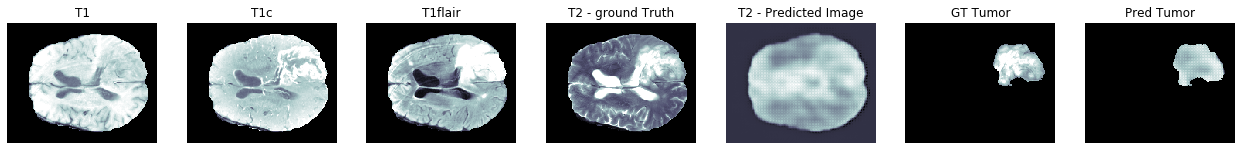

PSNR on validation set: 18.9880 ± 2.2902
MSE on validation set: 0.0140 ± 0.0055
SSIM on validation set: 0.6300 ± 0.1370

PSNR wrt tumor area on validation set: 30.8887 ± 7.3037
MSE wrt tumor area on validation set: 0.0016 ± 0.0012
SSIM wrt tumor area on validation set: 0.9593 ± 0.0309

Generator loss on validation set: 0.0502 ± 0.0097
Discriminator loss on validation set: 0.0154 ± 0.0158

Time taken for epoch 6 is 785.6822609901428 sec


Epoch:  7
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

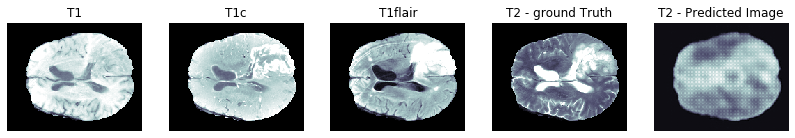

PSNR on validation set: 18.4709 ± 2.2245
MSE on validation set: 0.0156 ± 0.0058
SSIM on validation set: 0.6193 ± 0.1389

PSNR wrt tumor area on validation set: 30.8649 ± 7.2672
MSE wrt tumor area on validation set: 0.0016 ± 0.0012
SSIM wrt tumor area on validation set: 0.9578 ± 0.0330

Generator loss on validation set: 0.0490 ± 0.0115
Discriminator loss on validation set: 0.0108 ± 0.0077

Time taken for epoch 7 is 785.9324879646301 sec


Epoch:  8
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

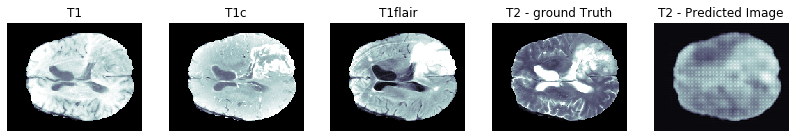

PSNR on validation set: 18.4969 ± 2.3127
MSE on validation set: 0.0157 ± 0.0068
SSIM on validation set: 0.6218 ± 0.1342

PSNR wrt tumor area on validation set: 30.9812 ± 7.1802
MSE wrt tumor area on validation set: 0.0015 ± 0.0010
SSIM wrt tumor area on validation set: 0.9582 ± 0.0316

Generator loss on validation set: 0.0493 ± 0.0118
Discriminator loss on validation set: 0.0100 ± 0.0110

Time taken for epoch 8 is 785.8682553768158 sec


Epoch:  9
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
........................

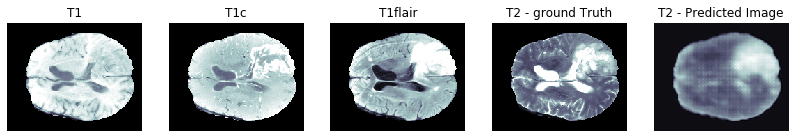

PSNR on validation set: 18.7730 ± 2.6803
MSE on validation set: 0.0152 ± 0.0070
SSIM on validation set: 0.6552 ± 0.1313

PSNR wrt tumor area on validation set: 31.1975 ± 7.0329
MSE wrt tumor area on validation set: 0.0014 ± 0.0010
SSIM wrt tumor area on validation set: 0.9624 ± 0.0283

Generator loss on validation set: 0.0417 ± 0.0102
Discriminator loss on validation set: 0.0719 ± 0.0141

Time taken for epoch 9 is 785.76340675354 sec


Epoch:  10
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
.........................

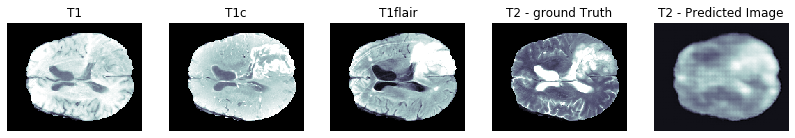

PSNR on validation set: 18.4232 ± 2.3680
MSE on validation set: 0.0161 ± 0.0073
SSIM on validation set: 0.6315 ± 0.1404

PSNR wrt tumor area on validation set: 31.0195 ± 7.2342
MSE wrt tumor area on validation set: 0.0015 ± 0.0011
SSIM wrt tumor area on validation set: 0.9611 ± 0.0298

Generator loss on validation set: 0.0503 ± 0.0102
Discriminator loss on validation set: 0.0110 ± 0.0087

Time taken for epoch 10 is 785.7170221805573 sec


Epoch:  11
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
......................

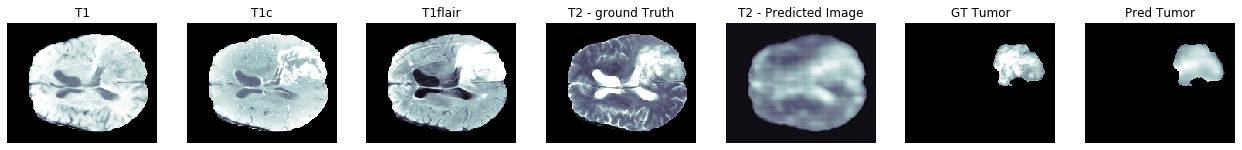

PSNR on validation set: 18.5473 ± 2.3066
MSE on validation set: 0.0155 ± 0.0061
SSIM on validation set: 0.6312 ± 0.1408

PSNR wrt tumor area on validation set: 30.8756 ± 7.3821
MSE wrt tumor area on validation set: 0.0016 ± 0.0014
SSIM wrt tumor area on validation set: 0.9601 ± 0.0330

Generator loss on validation set: 0.0512 ± 0.0103
Discriminator loss on validation set: 0.0088 ± 0.0045

Time taken for epoch 11 is 785.9969191551208 sec


Epoch:  12
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
......................

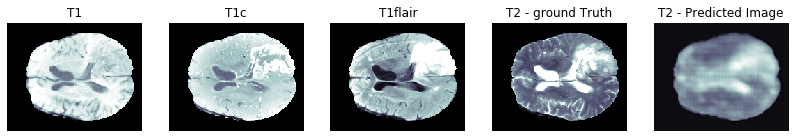

PSNR on validation set: 18.6884 ± 2.3659
MSE on validation set: 0.0151 ± 0.0063
SSIM on validation set: 0.6372 ± 0.1377

PSNR wrt tumor area on validation set: 30.9398 ± 7.6183
MSE wrt tumor area on validation set: 0.0016 ± 0.0014
SSIM wrt tumor area on validation set: 0.9603 ± 0.0327

Generator loss on validation set: 0.0499 ± 0.0095
Discriminator loss on validation set: 0.0080 ± 0.0036

Time taken for epoch 12 is 785.7357895374298 sec


Epoch:  13
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
......................

KeyboardInterrupt: ignored

In [50]:
EPOCHS = 17
save_checkpoint = False         # want to save new checkpoints ? 
save_final_models = False       # want to save the model at the end of the training ? 
epochs_already_trained = 0      # this is just for the print. 
evaluate_tumor_quality = True   # compute & print metrics on tumor area ?
print_loss = True               # compute & print the validation loss ?


# Initialize the models, so that I don't have to restart the runtime again.

if tf.equal(evaluate_tumor_quality, True) and tf.equal(print_loss, False):
    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = fit(training, EPOCHS, validation, save_checkpoint, 
                                                    epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor)

elif tf.equal(evaluate_tumor_quality, False) and tf.equal(print_loss, True):
    psnr, mse, ssim, gen_loss, dis_loss = fit(training, EPOCHS, validation, save_checkpoint, 
                                                    epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim)
    plot_loss(gen_loss, dis_loss)

elif tf.equal(evaluate_tumor_quality, True) and tf.equal(print_loss, True):
    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor, gen_loss, dis_loss = fit(training, EPOCHS, validation, save_checkpoint, 
                                                        epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor)
    plot_loss(gen_loss, dis_loss)
else:
    psnr, mse, ssim = fit(training, EPOCHS, validation, save_checkpoint, 
                                                      epochs_already_trained, evaluate_tumor_quality, print_loss)
    plot_metrics(psnr, mse, ssim)

# at the end, I'll save the models (I would need only the gen, but let's sayve also the disc  )
# (it saves the entire model to a HDF5 file)

if save_final_models:
    generator.save('drive/My Drive/MRI-generation/gen_t2_17&instance_MI-GAN.h5')

##Evaluating the final model with the test set

In [0]:
# Let's check the scores of this model.

evaluate_GAN(generator, testing, 'test', True, True)

## Considerations about metrics and normalization

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    prediction = generator(inp, training=False)
    inp, ground_truth, prediction = resize_with_crop(inp, ground_truth, prediction)

    prediction_normalized = mean_normalize(prediction)
    ground_truth_normalized = mean_normalize(ground_truth) 

    #prediction_normalized2 = min_max_normalize(prediction)
    
    # remove black images from ground_truth is not that necessary because it's enough to do it on the predictions. 
    # Anyway, just to be sure, let's remove them also from the ground truth (so the metrics of those images will be ignored)

    # BLACK IMAGES ARE DISCARDED IN ALL THE METRICS COMPUTED. Both in the case where I normalize and in the one in which I don't.
    # What if, in the case in which I don't normalize, I keep the black images? We would have significant differences.
    # For example PSNR would be 27.0207 ± 10.2544 instead of  25.2498 ± 2.8603 (with the model trained)
    ground_truth = black_images_to_nan(ground_truth)
    prediction = black_images_to_nan(prediction)

    #mean, std, psnr = compute_psnr(ground_truth, prediction_normalized2)
    #print("PSNR w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, psnr = compute_psnr(ground_truth_normalized, prediction_normalized)
    print("PSNR w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, psnr = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print()
    #mean, std, ssim = compute_ssim(ground_truth, prediction_normalized2)
    #print("SSIM w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, ssim = compute_ssim(ground_truth_normalized, prediction_normalized)
    print("SSIM w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, ssim = compute_ssim(ground_truth, prediction)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print()
    #mean, std, mse = compute_mse(ground_truth, prediction_normalized2)
    #print("SSIM w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, mse = compute_mse(ground_truth_normalized, prediction_normalized)
    print("MSE w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, mse = compute_mse(ground_truth, prediction)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

## Additional notes

Implementation of MI-GAN with instance normalization and with the discriminator loss multiplied by 0.5 doesn't reach good results: CONVERGENCE FAILURE. 
The discriminator loss was stable and very close to zero. Why this? Generator is not producing good enough images so the work for the Discirminator is pretty easy. There is something about fake images that makes them very easy for the D to identify. 

In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# with a batch_size of 32, we have 112 elements in the prefetched TEST set so 3584 samples.
# in the VALIDATION SET: 108 elements * 32 (batch_size) = 3456 samples.
# in the TRAINING set: 876 elements * 32 = 28032

# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32/33
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size

# tradeoff between 32 and 64. 32 seems to be qualitatively more accurate but it's a bit slower. 
# before choosing, it would be better to implement also the quantitative metrics.

# from pix2pix paper: use batch sizes between 1 and 10 depending on the experiment


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.

In [0]:
# np.FUNCTION VS tf.FUNCTION

# np =  training with 31 samples and bs = 32 (992 samples fed to the GAN), GPU took 28/32/33
# training with 32 samples and bs = 32 (1024 samples fed to the GAN), GPU took 14/15/16/17 seconds 